Autoencoders has an architecture which takes input and project it to lower dimension (using neural layers) and then try to reconstruct the original image using the projection. This is helpful for:
- Visualization (By projecting it to lower dimension, it can easily be plotted and hence visualize for getting insights)
- Clustering (Since image has to be reconstructed using the projection, projection learns good lower dimension representation of an image which can be helpful for clustering similar images)
- Image compression
- Image translation (From latent dimension when image is reconstructed, it can be another image [not input] so it can also help in image to image translation)

MNIST is used for training the architectures

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
import wandb

# Helper

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def visualize_tensors():
    pass

def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

## Hyperparameters

In [3]:
batch_size = 64
input_vector = 784

# Load Data

In [4]:
transform = transforms.Compose([#transforms.RandomHorizontalFlip(p = 0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,], [0.5,])])
inv_transform = transforms.Compose([transforms.Normalize([0.,], [1/0.5,]),
                                   transforms.Normalize([-0.5,], [1.,])])
mnist_train = datasets.MNIST('data/', train = True, transform=transform, download=True)
mnist_val = datasets.MNIST('data/', train=False, transform=transform, download=True)
trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
validloader = DataLoader(mnist_val, batch_size=batch_size, num_workers=8, pin_memory=True)

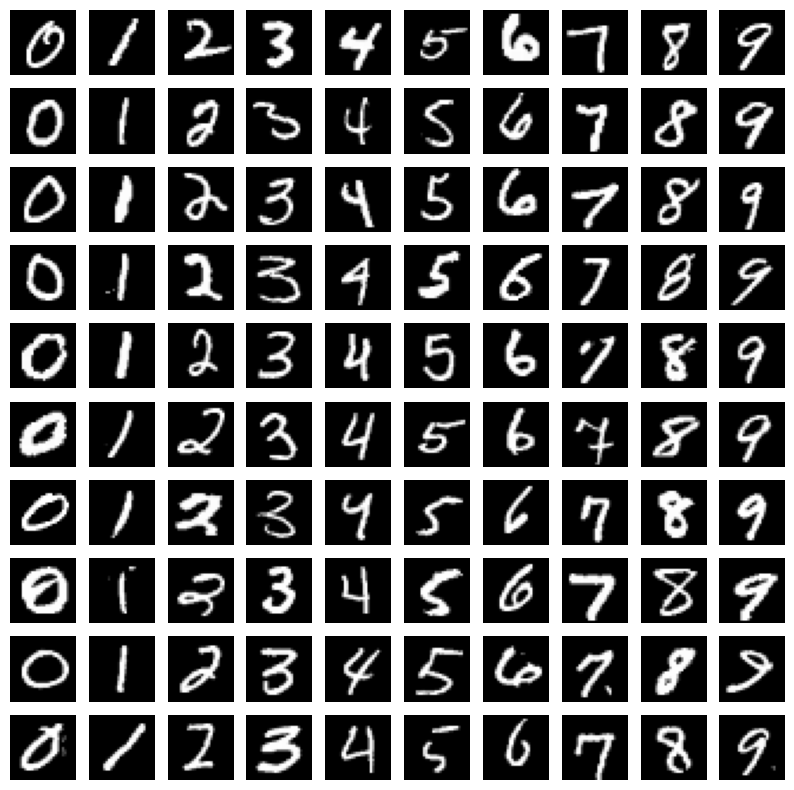

In [5]:
# Visualizing Data
train_images, train_labels = mnist_train.data, mnist_train.targets
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

# Vanilla Autoencoder

## Model

In [ ]:
# Setting first experiment
wandb.init(project='Autoencoder', name="vanilla_autoencoder")
hidden_dim = [128, 64]
latent_dim = 2
learning_rate = 1e-02
num_epochs = 20
criterion = nn.MSELoss()
save_path = './saved_models/vanilla_auto.pt'

wandb.config = {
    'batch_size': 64,
    'hidden_dim': hidden_dim,
    'latent_dim': latent_dim,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'loss': 'mean_squared_error'
}
wandb.log({"data_visualize": fig})

In [7]:
class VanillaAutoencoder(nn.Module):
    def __init__(self, input_vector, hidden_units, latent_dim):
        super(VanillaAutoencoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector[0]
        all_units = input_vector + hidden_units + latent_dim
        for i in range(len(all_units) - 1):
            temp = [nn.Linear(all_units[i], all_units[i+1]),
                    nn.ReLU()]
            enc_list.extend(temp)

        # Remove ReLU of last layer
        enc_list.pop()

        self.encoder = nn.Sequential(*enc_list)
        
        for i in range(len(all_units) - 1, 0, -1):
            temp = [nn.Linear(all_units[i], all_units[i-1]),
                    nn.ReLU()]
            dec_list.extend(temp)

        dec_list.pop()
        dec_list.append(nn.Tanh())
        self.decoder = nn.Sequential(*dec_list)

    def forward(self, x):
        x = x.view(-1, self.inp_dim)
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [8]:
van_autoencoder = VanillaAutoencoder([input_vector], hidden_dim, [latent_dim])
summary(van_autoencoder, (28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 2]                   130
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  192
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [9]:
def visualization(dataloader, model, title, clear = True):
    model.eval()
    encoder = model.encoder
    decoder = model.decoder
    num_examples = {i:10 for i in range(10)}
    fig_1, axes_1 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    fig_2, axes_2 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    x_value = []
    y_value = []
    labels = []
    i = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, total = len(dataloader), leave = False)
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            imgs_inp = imgs.view(-1, input_vector)
            embeddings = encoder(imgs_inp)
            out = decoder(embeddings)
            out = out.view(len(out), 1, 28, 28)
            x_value.extend(embeddings[:,0].cpu().detach().numpy().tolist())
            y_value.extend(embeddings[:,1].cpu().detach().numpy().tolist())
            labels.extend(lbls.cpu().detach().numpy().tolist())
            for n in num_examples.keys():
                if num_examples[n] <= 0:
                    continue
                idxs = torch.where(lbls == n)[0][:num_examples[n]]
                num_examples[n] -= len(idxs)
                for idx in idxs:
                    idx = idx.item()
                    img = imgs[idx].detach().cpu().numpy()[0]
                    gen = out[idx].detach().cpu().numpy()[0]
                    axes_1[i//10, i%10].imshow(img, cmap = 'gray')
                    axes_1[i//10, i%10].axis('off')
                    axes_2[i//10, i%10].imshow(gen, cmap = 'gray')
                    axes_2[i//10, i%10].axis('off')
                    i+=1

    fig_3, axes = plt.subplots()
    x_value = np.array(x_value)
    y_value = np.array(y_value)
    labels = np.array(labels)
    color = plt.cm.get_cmap('tab10').colors
    color_dict = {i:color[i] for i in np.unique(labels)}
    for label, color in color_dict.items():
        ix = np.where(labels == label)
        color = np.array([color])
        axes.scatter(x_value[ix], y_value[ix], c = color, label = f"{label}", alpha = 0.8)
    axes.legend()
    wandb.log({f"{title}_original": fig_1, f"{title}_regenerated":fig_2, f"{title}_visualization": wandb.Image(fig_3)})
    if clear:
        fig_1.clear()
        plt.close(fig_1)
        fig_2.clear()
        plt.close(fig_2)
        fig_3.clear()
        plt.close(fig_3)

visualization(trainloader, van_autoencoder, "Pre_Train")
visualization(trainloader, van_autoencoder, "Pre_Valid");

In [10]:
def train_batch(imgs, model, criterion, optimizer, scaler, valid = False):
    optimizer.zero_grad()
    imgs, model = imgs.to(device, non_blocking = True), model.to(device)
    with torch.cuda.amp.autocast():
        out = model(imgs)
        imgs_flatten = imgs.view(-1, 784)
        batch_loss = criterion(out, imgs_flatten)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(trainloader, validloader, model, criterion, optimizer, num_epochs, load_check = False, best_valid_metric = 0.0, 
          save_path = './saved_models/checkpoint.pt'):    
    # Load From checkpoing
    if load_check:
        model = load_checkpoint(model, save_path)

    scaler = torch.cuda.amp.GradScaler()
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        model.eval()
        pbar = tqdm(validloader, total = len(validloader), leave = False)
        with torch.no_grad():
            for imgs, _ in pbar:
                imgs = imgs.to(torch.float32)
                current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, valid = True)
                batch_loss += current_batch_loss
                pbar.set_postfix(valid_loss = current_batch_loss)

        epoch_valid_loss = batch_loss / len(validloader)
        valid_losses.append(epoch_valid_loss)
        
        # Checkpoint
        if epoch_valid_loss < best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model, save_path)
            best_valid_metric = epoch_valid_loss
            
        wandb.log({'epoch':epoch ,'train_loss': epoch_train_loss, 'valid_loss': epoch_valid_loss})
        visualization(trainloader, van_autoencoder, "Epoch_train")
        visualization(validloader, van_autoencoder, "Epoch_valid")
        print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}
Valid Loss: {epoch_valid_loss:5.3f}
{"#"*33}''')
    return train_losses, valid_losses

In [ ]:
optimizer = optim.Adam(van_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, van_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, save_path=save_path)

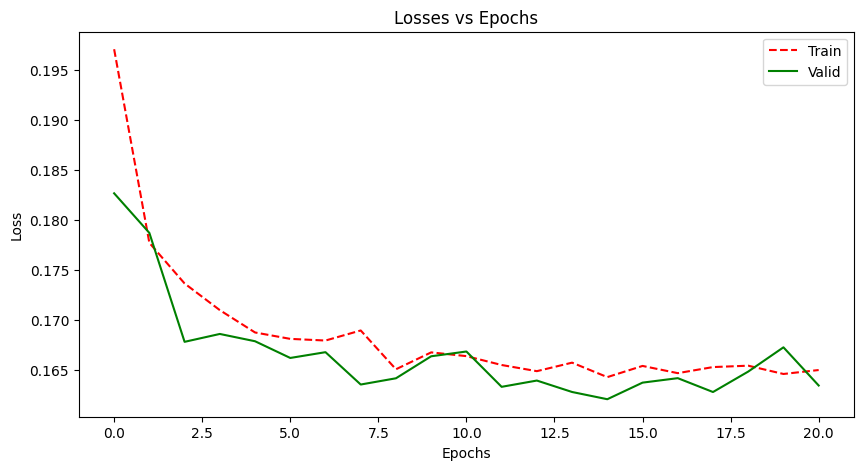

In [12]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show()

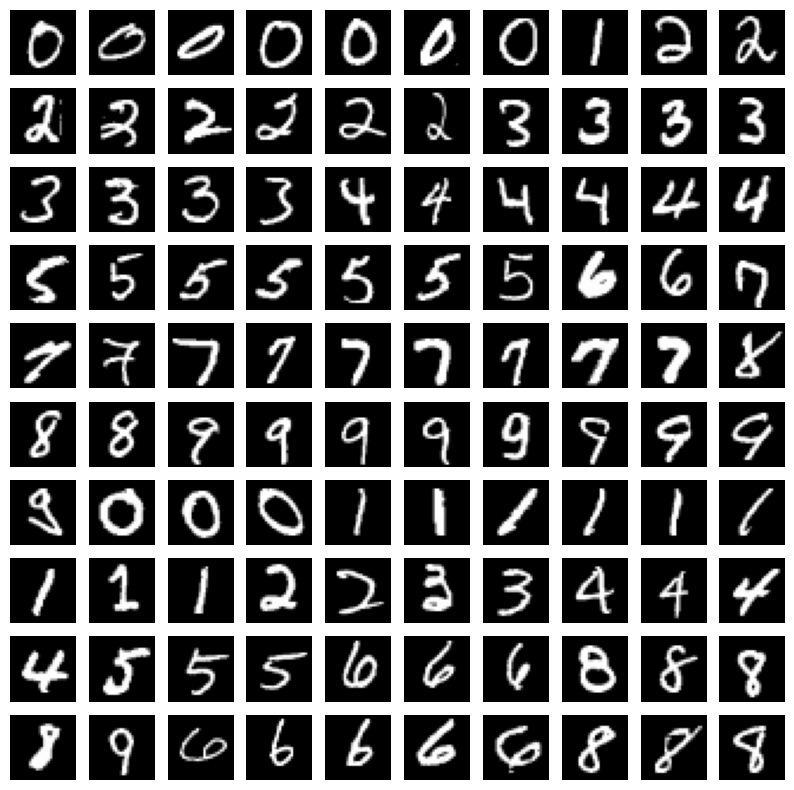

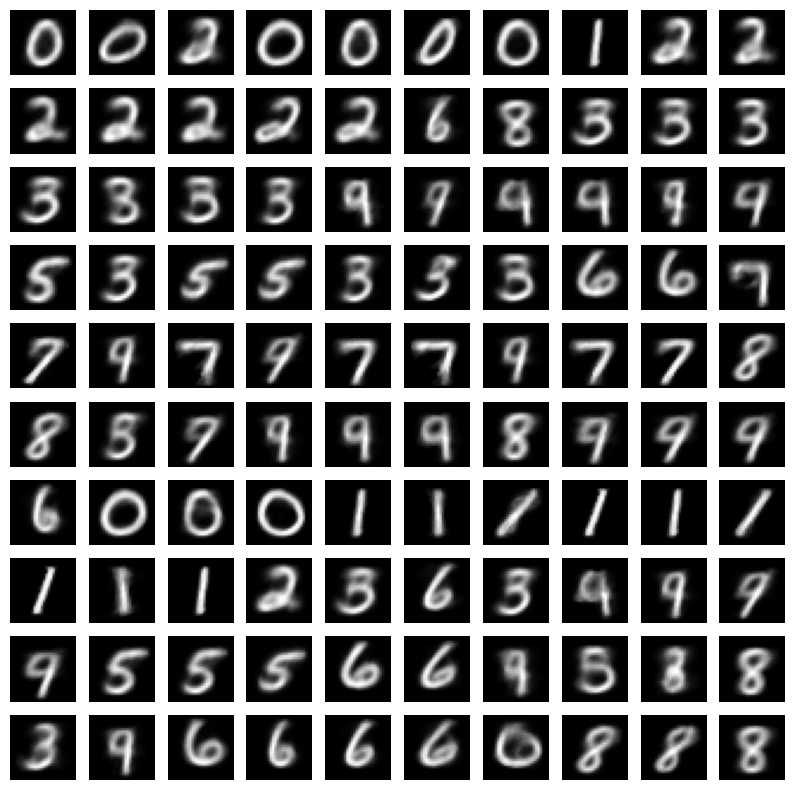

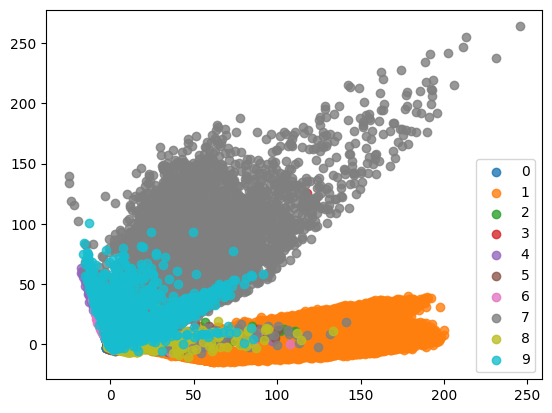

In [13]:
visualization(trainloader, van_autoencoder, "Post_train", clear = False)

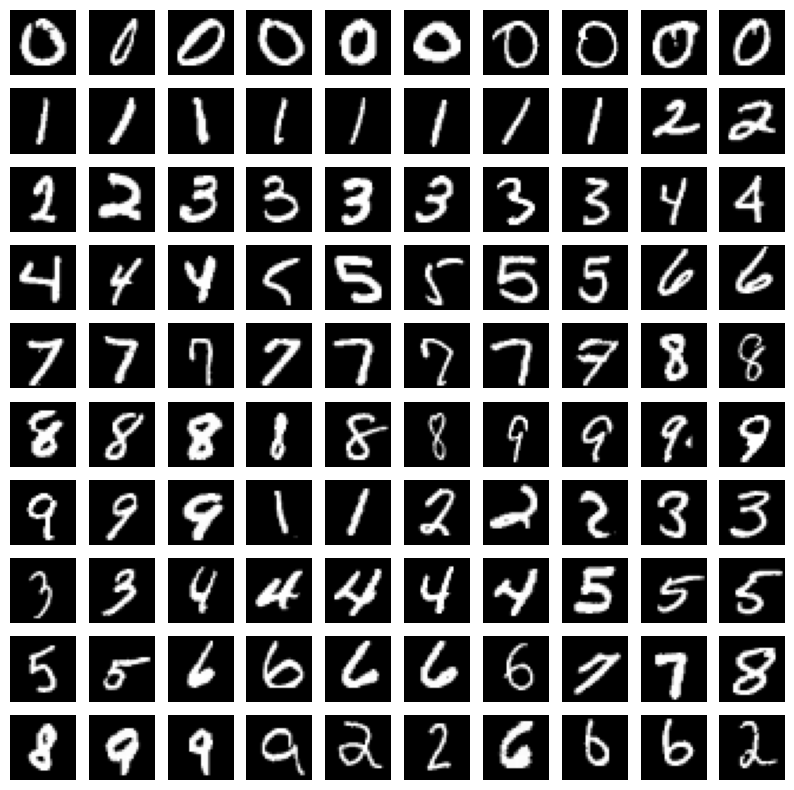

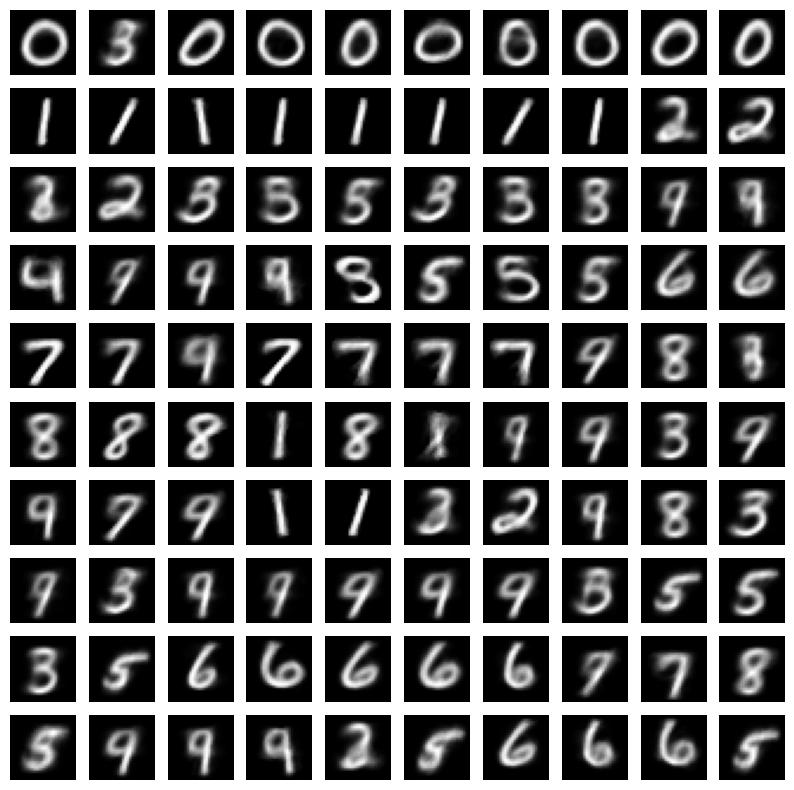

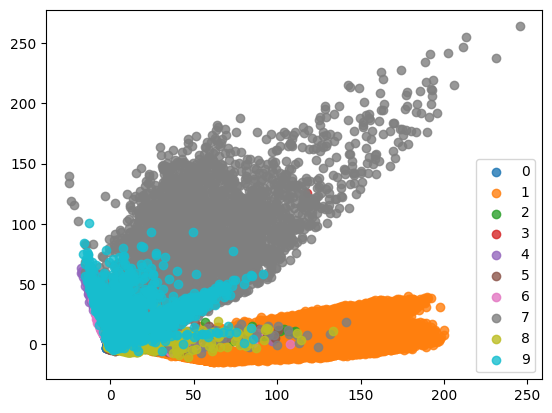

In [14]:
visualization(trainloader, van_autoencoder, "Post_valid", clear = False)

__NOTE:__ Images are bit dull, maybe adding batch norm might have an affect

# With Batchnorm

In [ ]:
# Setting first experiment
wandb.init(project='Autoencoder', name="vanilla_autoencoder (batchnorm)")
hidden_dim = [128, 64]
latent_dim = 2
learning_rate = 1e-02
num_epochs = 20
criterion = nn.MSELoss()
save_path = './saved_models/vanilla_auto_batch.pt'

wandb.config = {
    'batch_size': 64,
    'hidden_dim': hidden_dim,
    'latent_dim': latent_dim,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'loss': 'mean_squared_error'
}
wandb.log({"data_visualize": fig})

In [16]:
class VanillaAutoencoder(nn.Module):
    def __init__(self, input_vector, hidden_units, latent_dim):
        super(VanillaAutoencoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector[0]
        all_units = input_vector + hidden_units + latent_dim
        for i in range(len(all_units) - 1):
            temp = [nn.Linear(all_units[i], all_units[i+1]),
                    nn.BatchNorm1d(all_units[i+1]),
                    nn.ReLU()]
            enc_list.extend(temp)

        # Remove ReLU and batchnorm of last layer
        enc_list.pop()
        enc_list.pop()

        self.encoder = nn.Sequential(*enc_list)
        
        for i in range(len(all_units) - 1, 0, -1):
            temp = [nn.Linear(all_units[i], all_units[i-1]),
                    nn.BatchNorm1d(all_units[i-1]),
                    nn.ReLU()]
            dec_list.extend(temp)

        dec_list.pop()
        dec_list.pop()
        dec_list.append(nn.Tanh())
        self.decoder = nn.Sequential(*dec_list)

    def forward(self, x):
        x = x.view(-1, self.inp_dim)
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [17]:
van_autoencoder = VanillaAutoencoder([input_vector], hidden_dim, [latent_dim])
summary(van_autoencoder, (28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─BatchNorm1d: 2-2                  [-1, 128]                 256
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 64]                  8,256
|    └─BatchNorm1d: 2-5                  [-1, 64]                  128
|    └─ReLU: 2-6                         [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 2]                   130
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-8                       [-1, 64]                  192
|    └─BatchNorm1d: 2-9                  [-1, 64]                  128
|    └─ReLU: 2-10                        [-1, 64]                  --
|    └─Linear: 2-11                      [-1, 128]                 8,320

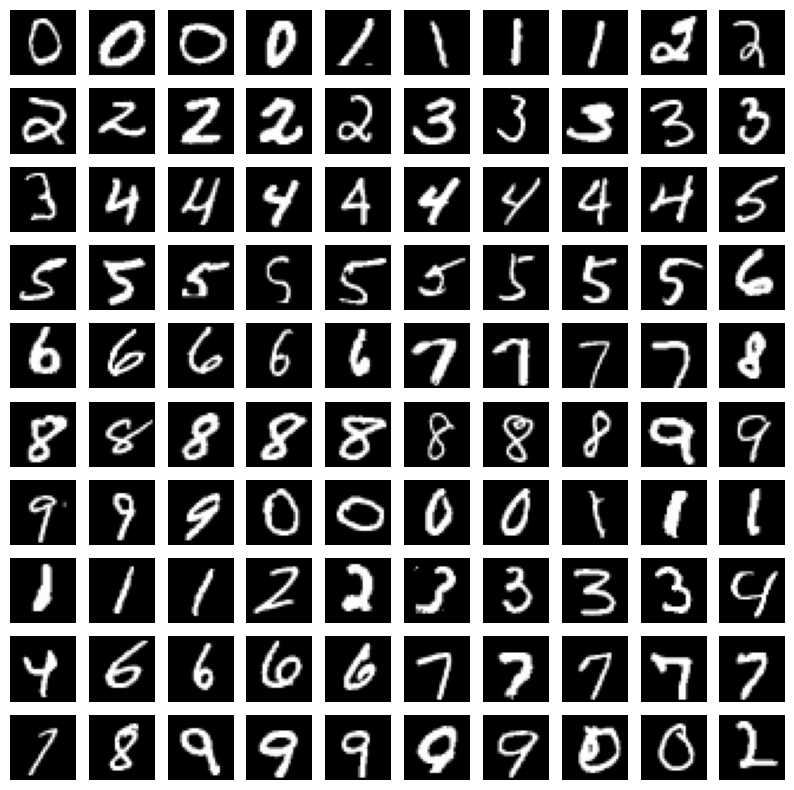

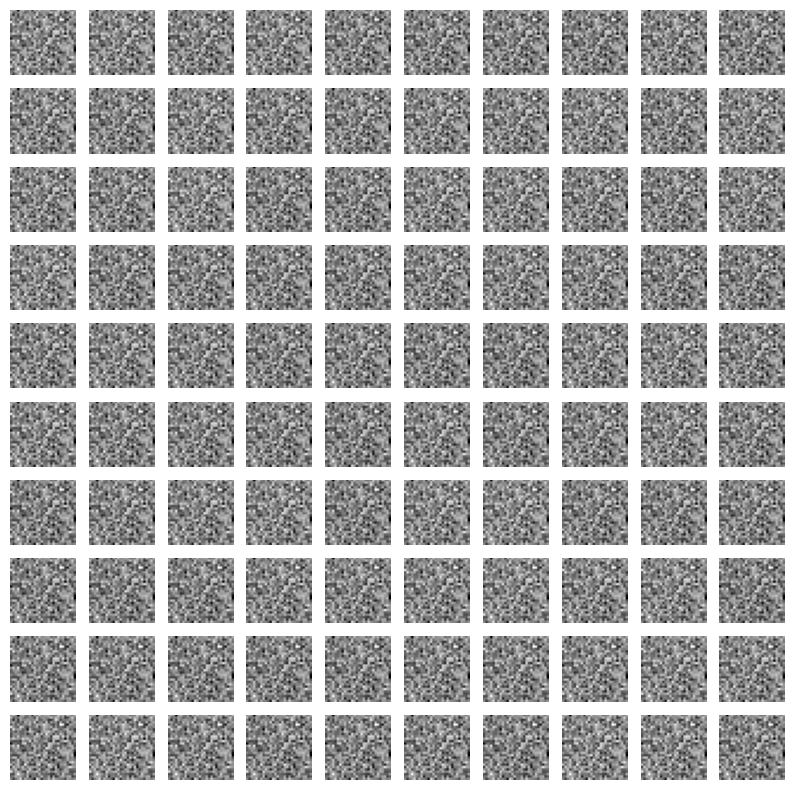

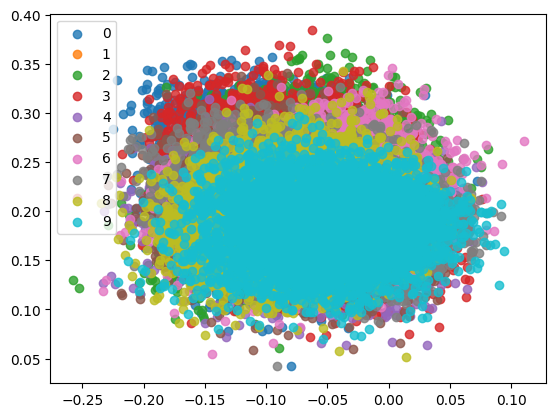

In [18]:
visualization(trainloader, van_autoencoder, "Pre_Train", clear = False)
visualization(trainloader, van_autoencoder, "Pre_Valid");

In [ ]:
optimizer = optim.Adam(van_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, van_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, save_path=save_path)

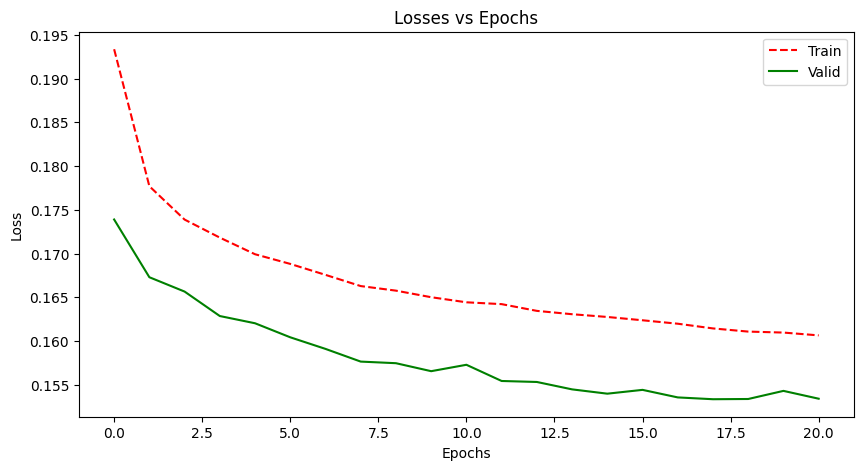

In [20]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show()

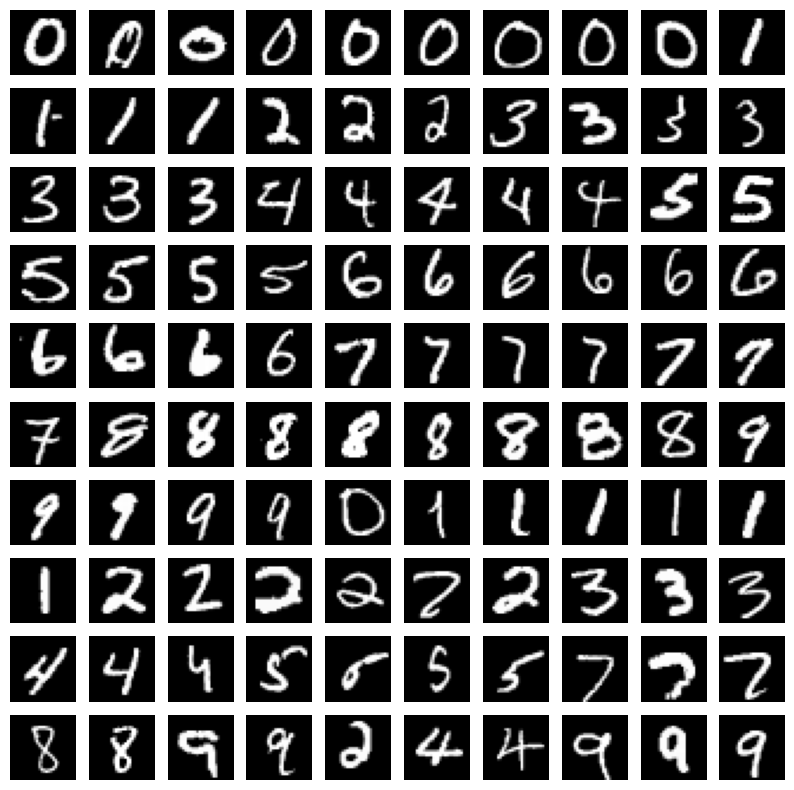

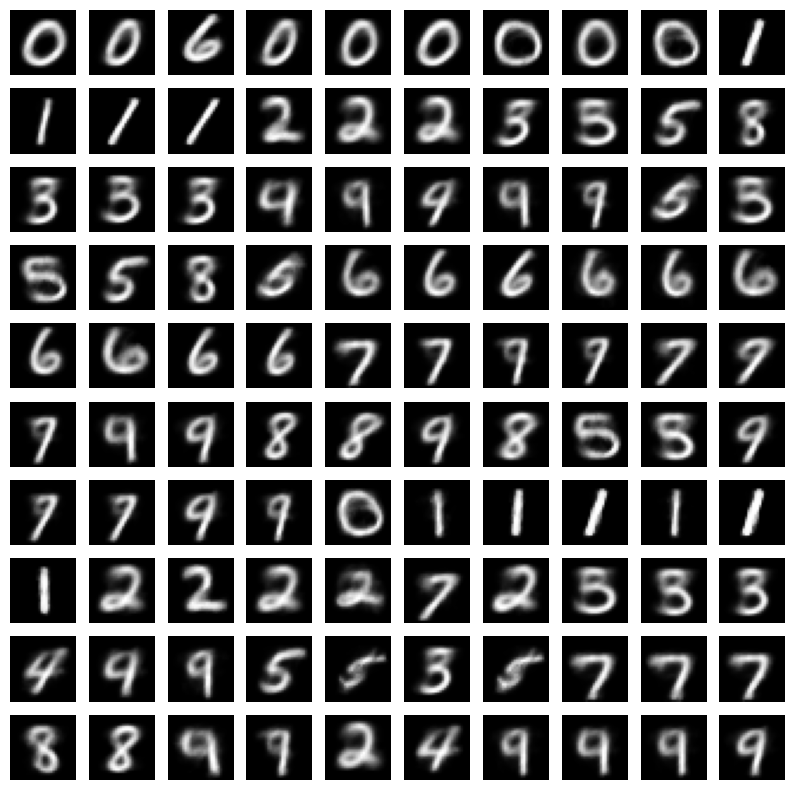

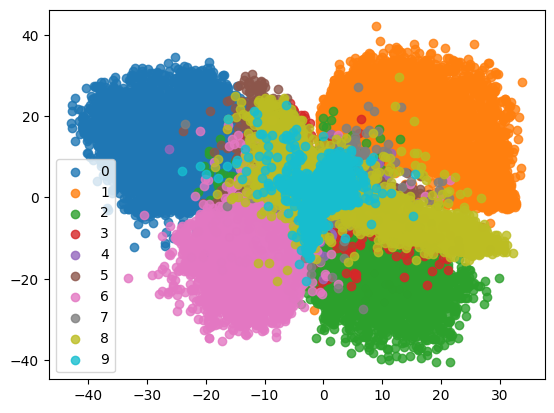

In [21]:
visualization(trainloader, van_autoencoder, "Post_train", clear = False)

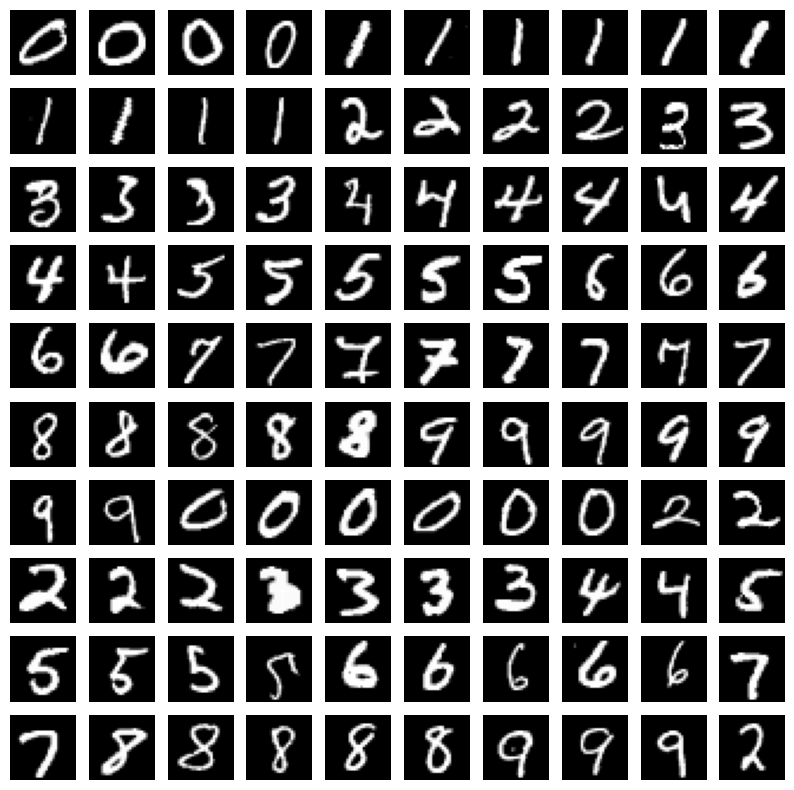

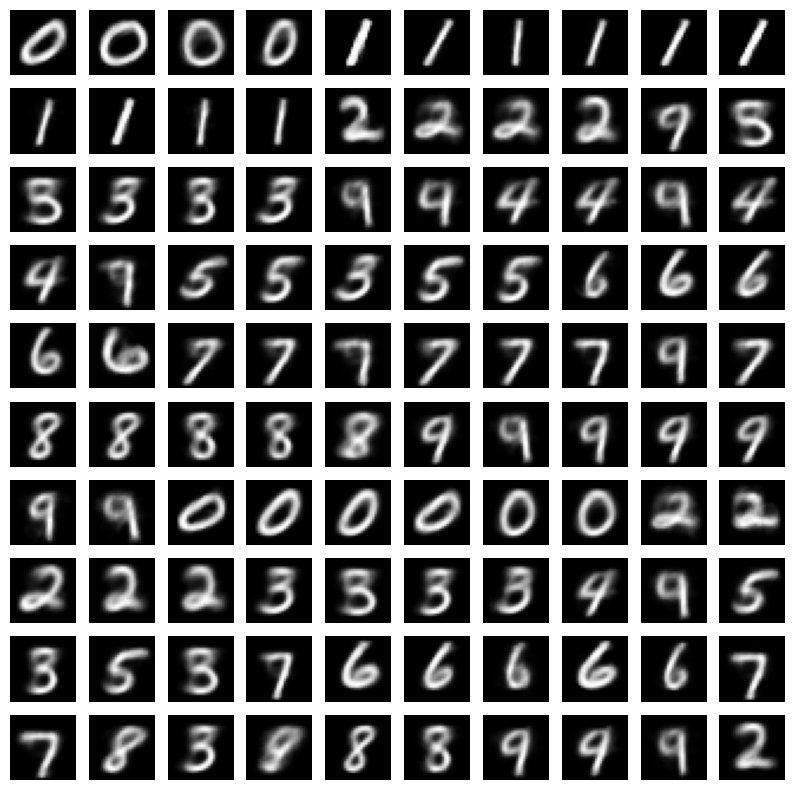

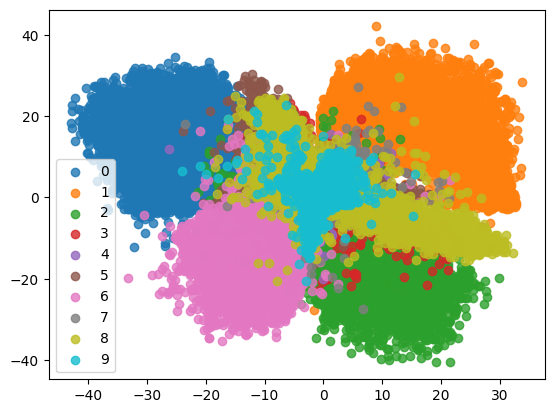

In [22]:
visualization(trainloader, van_autoencoder, "Post_valid", clear = False)

__NOTE:__ Results while using batchnorm is better than normally using without batchnorm. Now trying the results with more linear layers

# Hyperparameter Tuning

## 1.) Changing hidden_dim

In [ ]:
# Setting first experiment
wandb.init(project='Autoencoder', name="vanilla_autoencoder (batchnorm)")
hidden_dim = [256, 128, 64]
latent_dim = 2
learning_rate = 1e-02
num_epochs = 20
criterion = nn.MSELoss()
save_path = './saved_models/vanilla_auto_batch.pt'

wandb.config = {
    'batch_size': 64,
    'hidden_dim': hidden_dim,
    'latent_dim': latent_dim,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'loss': 'mean_squared_error'
}

In [24]:
van_autoencoder = VanillaAutoencoder([input_vector], hidden_dim, [latent_dim])
summary(van_autoencoder, (28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Linear: 2-1                       [-1, 256]                 200,960
|    └─BatchNorm1d: 2-2                  [-1, 256]                 512
|    └─ReLU: 2-3                         [-1, 256]                 --
|    └─Linear: 2-4                       [-1, 128]                 32,896
|    └─BatchNorm1d: 2-5                  [-1, 128]                 256
|    └─ReLU: 2-6                         [-1, 128]                 --
|    └─Linear: 2-7                       [-1, 64]                  8,256
|    └─BatchNorm1d: 2-8                  [-1, 64]                  128
|    └─ReLU: 2-9                         [-1, 64]                  --
|    └─Linear: 2-10                      [-1, 2]                   130
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-11                      [-1, 64]                  19

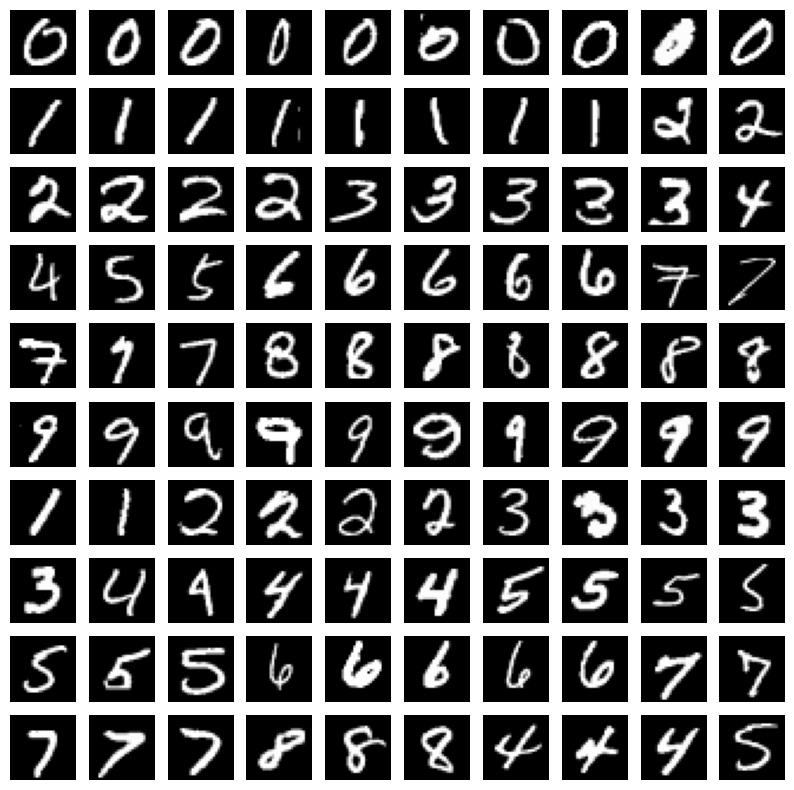

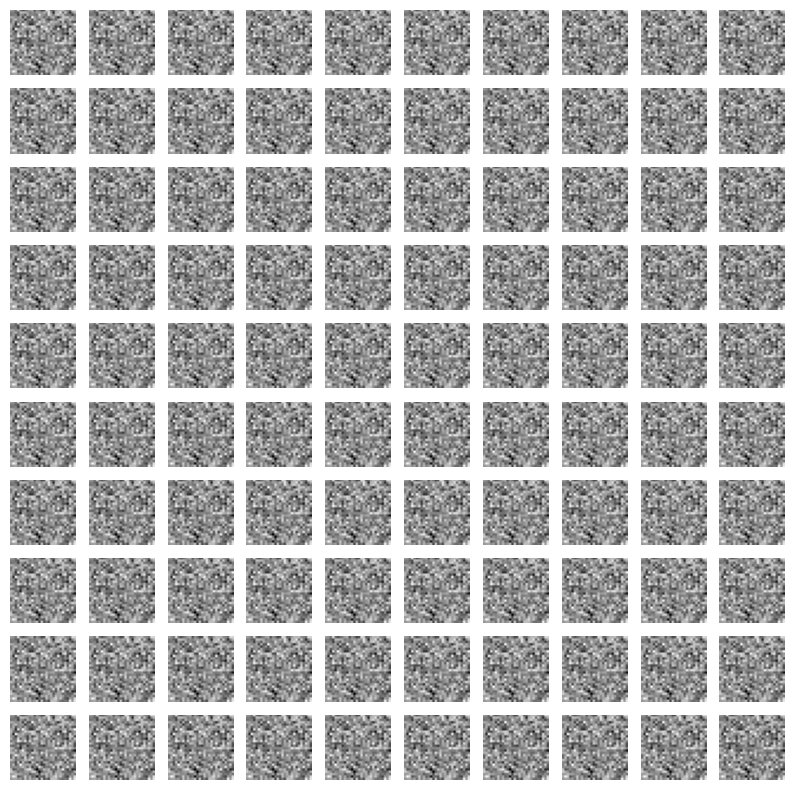

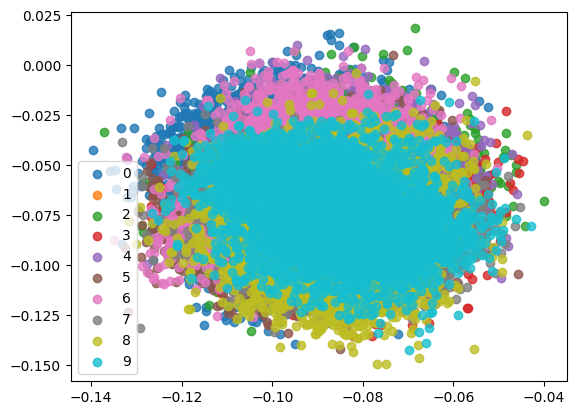

In [25]:
visualization(trainloader, van_autoencoder, "Pre_Train", clear = False)
visualization(trainloader, van_autoencoder, "Pre_Valid");

In [ ]:
optimizer = optim.Adam(van_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, van_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, save_path=save_path)

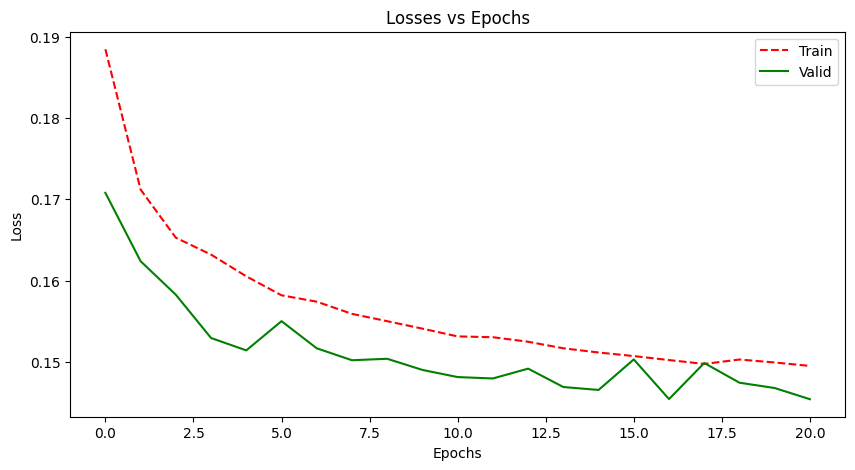

In [27]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show()

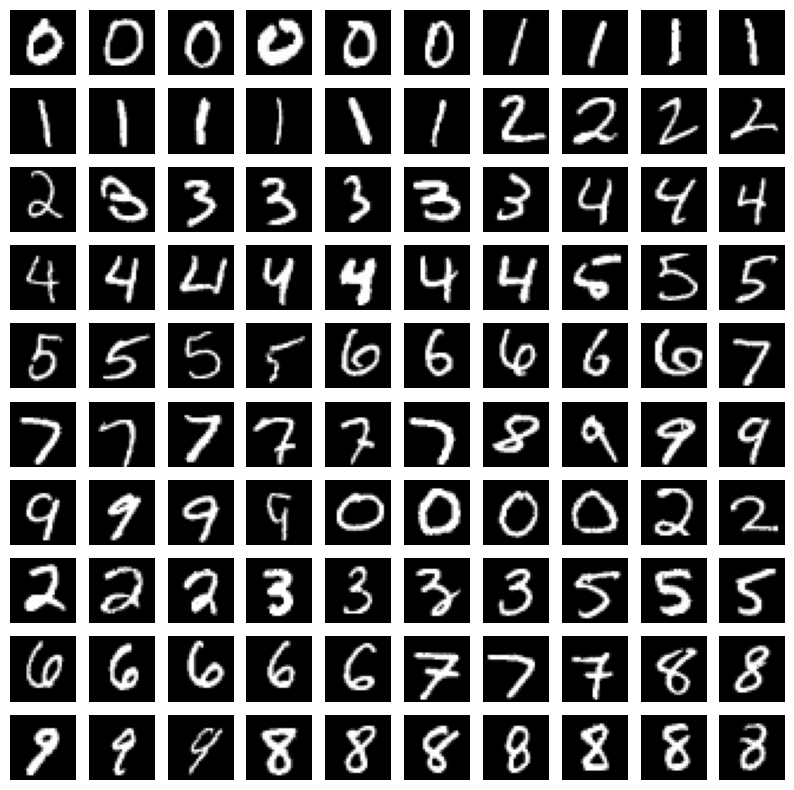

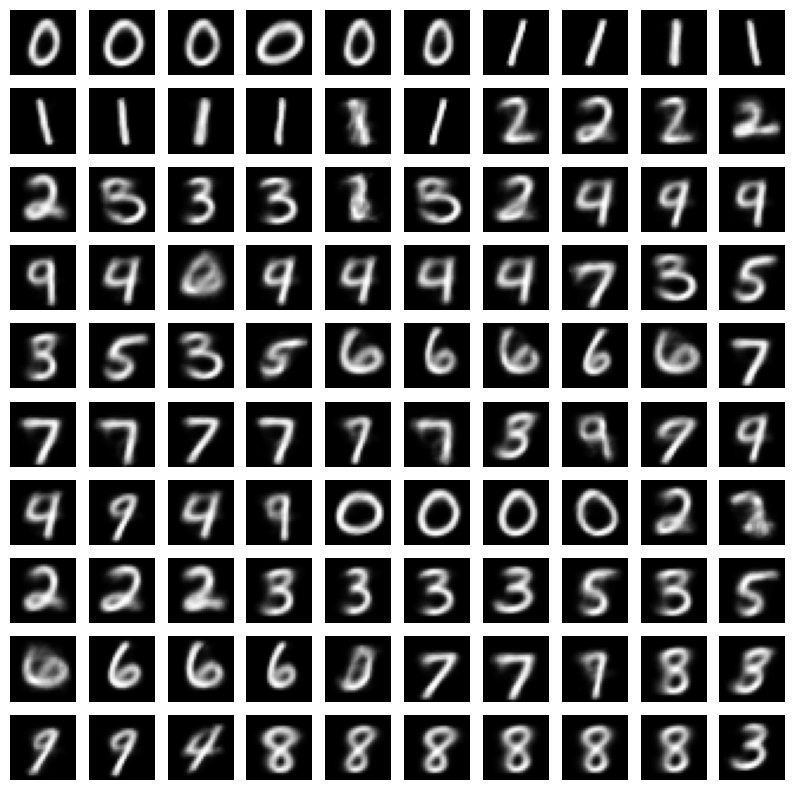

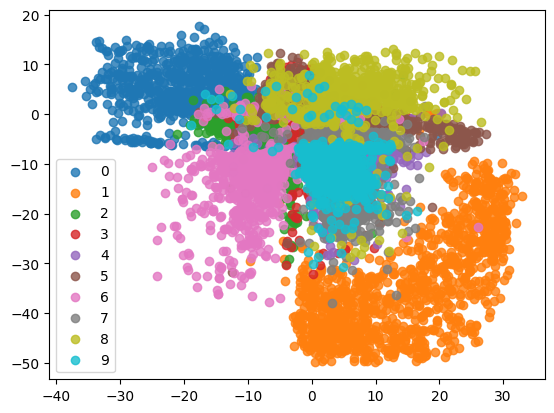

In [28]:
visualization(validloader, van_autoencoder, "Post_valid", clear = False)